In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from questionnaire_scoring import (
    pdc_get_timepoint_1,
    process_questionnaire
    )
from data_functions import (
    convert_df_type,
    scaling, 
    pca_permulation,
    merge_dataframes,
    scaled_data,
    impute_group_median,
    determine_number_of_clusters,
    fit_pca,
    clustering

)
from factor_analysis import data_fit, create_loading_design_matrix, model_fit_parameters, cfa_model
from sklearn.decomposition import KMeans
import seaborn as sns
sns.set_style('dark')

ImportError: cannot import name 'impute_group_median' from 'data_functions' (/Users/mszdjh3/code/conilab/conilab/hcp-disease/data_functions.py)

In [202]:
base_dir = os.path.join(os.environ['HOME'], 'data', 'HCP-disease', 'behavioural')
banda_part = pd.read_csv("sub_ids/banda_id.csv")
banda_key = pd.read_csv(os.path.join(base_dir, 'BANDA', 'tmp', 'BANDAinfocomplete.csv'))
banda_key['ALL_Data'] = banda_key['ALL_Data'].str.replace('_MR','')
banda_key = banda_key[['ALL_Data', 'phenotype', 'sex','interview_age']].rename(columns={"ALL_Data": "id"})
band_particpant_info = pd.merge(banda_key, banda_part, left_on='id', right_on='part', how='right').drop('part', axis=1)
banda_df = pd.read_excel(os.path.join(base_dir, 'BANDA', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [203]:
pdc_key = pd.read_excel(os.path.join(base_dir, 'pdc', 'DemographicFiles.xlsx'))[1:]
pdc_key = pdc_key[['src_subject_id', 'phenotype', 'sex', 'interview_age']]
pdc_key['phenotype'] = pdc_key['phenotype'].str.replace('CONTROL', 'Control').str.replace('TSD Control', 'Control').str.replace("TSD MDD", "MDD").str.replace('HEALTHY', '').str.lstrip()
pdc_key['src_subject_id'] = pdc_key['src_subject_id'].str.lstrip()
pdc_particpant_info = pdc_key.rename(columns={"src_subject_id": "id"})
pdc_df = pd.read_excel(os.path.join(base_dir, 'PDC', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [204]:
shap_df_pdc = pdc_get_timepoint_1(pdc_df['shaps01'], pdc_particpant_info)[['id', 'phenotype', 'shaps1', 'shaps2', 'shaps3', 'shaps4', 'shaps5', 'shaps6',
       'shaps7', 'shaps8', 'shaps9', 'shaps10', 'shaps11', 'shaps12',
       'shaps13', 'shaps14']]
quick_depress_pdc = pdc_get_timepoint_1(pdc_df['qids01'], pdc_particpant_info)[['id', 'phenotype', 'vsoin',
       'vmnin', 'vemin', 'vhysm', 'vmdsd', 'vcntr', 'vvwsf', 'vsuic',
       'vintr', 'vengy', 'vslow', 'vagit', 'qvtot',]]
dass_pdc = pdc_get_timepoint_1(pdc_df['dass01'], pdc_particpant_info)[['id', 'phenotype' ,'dass_1',
       'dass_2', 'dass_4', 'dass_6', 'dass_7', 'dass_8', 'dass_9', 'dass_11',
       'dass_12', 'dass_14', 'dass_15', 'dass_18', 'dass_19', 'dass_20']]
depresion_scale = pdc_get_timepoint_1(pdc_df['hrsd01'], pdc_particpant_info)[['id', 'phenotype', 'hmnin', 'hemin', 'hmdsd', 'hpanx', 'hinsg', 'happt', 'hwl', 'hsanx',
       'hhypc', 'hvwsf', 'hsuic', 'hintr', 'hengy', 'hslow', 'hagit', 'hsex']]
bids = pdc_get_timepoint_1(pdc_df['bisbas01'], pdc_particpant_info)[['id', 'bissc_total', 'bas_drive', 'bas_fs', 'bas_rr']]
apathy_scale = pdc_get_timepoint_1(pdc_df['apath01'], pdc_particpant_info)[['id', 'phenotype', 'apath_01',
       'apath_02', 'apath_03', 'apath_04', 'apath_05', 'apath_06', 'apath_07',
       'apath_08', 'apath_09', 'apath_10', 'apath_11', 'apath_12', 'apath_13',
       'apath_14', 'apath_15', 'apath_16', 'apath_17', 'apath_18',]]

In [34]:
quick_depress_pdc = quick_depress_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
dass_pdc = dass_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
depresion_scale = depresion_scale.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
apathy_scale = apathy_scale.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)

In [36]:
pdc_scores = merge_dataframes([shap_df_pdc, quick_depress_pdc, dass_pdc, depresion_scale, bids, apathy_scale])

In [39]:
pdc_loadings_dict = {
    "anxiety": dass_pdc.columns[1:].to_list() + ['bissc_total'],
    "depression": quick_depress_pdc.columns[1:].to_list() + shap_df_pdc.columns[2:].to_list() + ['bas_drive', 'bas_fs', 'bas_rr',] + depresion_scale.columns[1:].to_list() + apathy_scale.columns[1:].to_list(),
    'mood': shap_df_pdc.columns[2:].to_list() + quick_depress_pdc.columns[1:].to_list() +  dass_pdc.columns[1:].to_list() + depresion_scale.columns[1:].to_list() + apathy_scale.columns[1:].to_list() + bids.columns[1:].to_list()
}
pdc_columns = pdc_loadings_dict['anxiety'] +  pdc_loadings_dict['depression']
pdc_matrix = create_loading_design_matrix(pdc_loadings_dict, pdc_columns)

In [40]:
pdc_data_fit = data_fit(convert_df_type(pdc_scores[pdc_columns]))
print(pdc_data_fit['kmo_all'])
print('bart pval', pdc_data_fit['kmo_model'])
print('kmo_model pval', pdc_data_fit['bartlett_pval'])
print('bart chi2',pdc_data_fit['bartlett_chi2'])

          KMO Score
dass_1     0.933732
dass_2     0.876582
dass_4     0.882786
dass_6     0.900798
dass_7     0.915634
...             ...
apath_14   0.931834
apath_15   0.944973
apath_16   0.925237
apath_17   0.879414
apath_18   0.946915

[79 rows x 1 columns]
bart pval 0.9153947473488518
kmo_model pval 0.0
bart chi2 18159.52515844034


<Axes: >

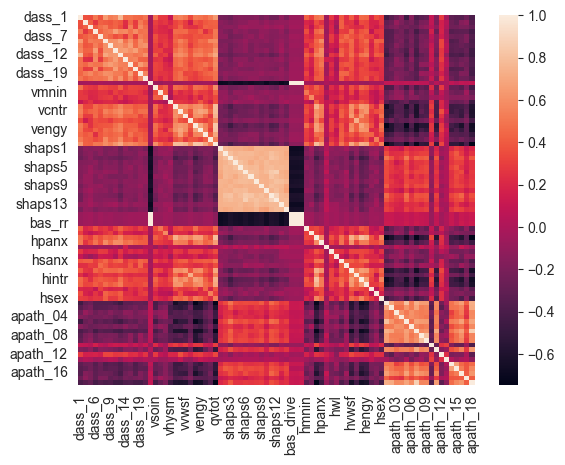

In [41]:
sns.heatmap(pdc_scores[pdc_columns].corr())

In [42]:
pdc_scaled = scaled_data(pdc_scores[pdc_columns])
pdc_model = cfa_model(pdc_matrix, pdc_scaled, 3, len(pdc_columns), [key for key in pdc_loadings_dict.keys()])

In [ ]:
fit = model_fit_parameters(pdc_model, pdc_scaled, cols=pdc_columns)
display(fit['loadings'])
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

In [152]:
pdc_data = pd.concat([pdc_particpant_info[['id', 'phenotype', 'interview_age', 'sex']].reset_index(drop=True), 
                        pd.DataFrame(pdc_model.fit_transform(pdc_scaled)).rename(columns={0: "Anxiety", 1:"Depression", 2: "mood"})], axis=1)

<Axes: >

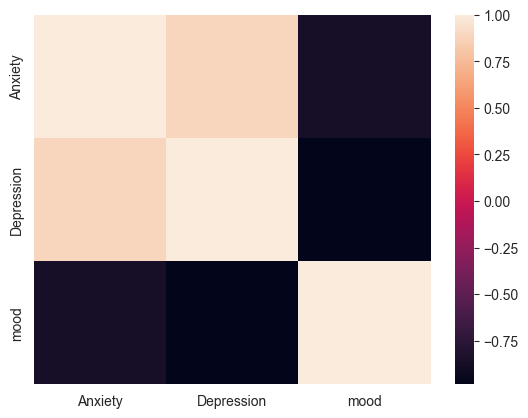

In [48]:
sns.heatmap(pdc_data[['Anxiety', 'Depression', 'mood']].corr()
)

<Axes: >

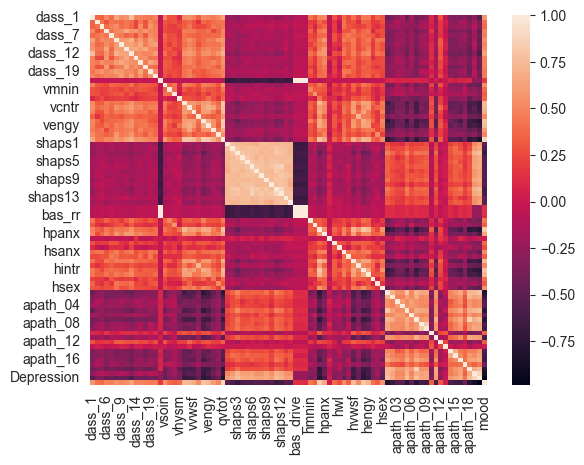

In [25]:
sns.heatmap(pd.concat([pdc_scores[pdc_columns], pdc_data[['Anxiety', 'Depression', 'mood']]], axis=1).corr()
)

## BANDA symptoms

In [109]:
sub_scores = {
    "social_phobia": [4, 7, 8, 12, 20, 30, 32, 38, 43],
    "panic_disorder": [3, 14, 24, 26, 28, 34, 36, 39, 41],
    "maj_depression": [2, 6, 11, 15, 19, 21, 25, 29, 40, 47],
    "seperation_anxiety": [5, 9, 17, 18, 33, 45, 46],
    "general_anxiety": [1, 13, 22, 27, 35, 37],
    "ocd": [10, 16, 23, 31, 42, 44]
}

rdacs_score = {
    "Never": 0,
    "Sometimes": 1,
    "Often": 2,
    "Always": 3
}
rcads01 = banda_df["rcads01"][banda_df["rcads01"]['visit'] == 'T1']
rcads01 = rcads01.drop(rcads01[rcads01['src_subject_id'].duplicated()].index)
rcads_cols = rcads01.columns[8:]
scored_df = rcads01[rcads_cols].replace(rdacs_score)
scores = dict(zip([key for key in sub_scores], [[] for key in sub_scores]))
scores['particpant'] = rcads01['src_subject_id'].loc[1:]

for sub_scal in sub_scores:
    scores[sub_scal] = scored_df.loc[:, [f"rcads_{str(index)}" for index in sub_scores[sub_scal]]].sum(axis=1)

rcads_df = pd.DataFrame(
    data = scores
)
cols = rcads_df.columns.tolist()
cols = [cols[-1]] + cols[1:-1] + [cols[0]]
cols = cols[:1] + [cols[2]] + [cols[1]] + cols[3:]
rcads_df = rcads_df[cols]

try:
    del(rcads_df['internalising'])
    del(rcads_df['anxiety'])
except Exception as e:
    pass
rcads_df['internalising'] = rcads_df.iloc[:, 1:].sum(axis=1)
rcads_df['anxiety'] = rcads_df.iloc[:, 2:7].sum(axis=1)
rcads_df = rcads_df.rename(columns={"particpant": "id"})

In [ ]:
mfg_score = process_questionnaire(banda_df['mfq01'], band_particpant_info, 'mfq01_id')[['id', 'phenotype', 'mfqc1_1',
       'mfqc1_2', 'mfqc1_3', 'mfqc1_4', 'mfqc1_5', 'mfqc1_6', 'mfqc2_1',
       'mfqc2_2', 'mfqc2_3', 'mfqc2_4', 'mfqc2_5', 'mfqc2_6', 'mfqc3_1',
       'mfqc3_2', 'mfqc3_3', 'mfqc3_4', 'mfqc3_5', 'mfqc3_6', 'mfqc4_1',
       'mfqc4_2', 'mfqc4_3', 'mfqc4_4', 'mfqc4_5', 'mfqc4_6', 'mfqc5_1',
       'mfqc5_2', 'mfqc5_3', 'mfqc5_4', 'mfqc5_5', 'mfqc6_1', 'mfqc6_2',
       'mfqc6_3', 'mfqc6_4' ]]
stai01_score = process_questionnaire(  banda_df["stai01"], 
    band_particpant_info, 
    'stai01_id', )[[  'id', 'phenotype', 'stai1',
       'stai2', 'stai3', 'stai5', 'stai6', 'stai7', 'stai10', 'stai11',
       'stai12', 'stai13', 'stai15', 'stai16', 'stai17', 'stai20', 'stai21',
       'stai24', 'stai26', 'stai27', 'stai28', 'stai29', 'stai30', 'stai32',
       'stai33', 'stai36', 'stai37', 'stai38', 'stai39', 'stai40',
       'stai_state4_i', 'stai_state8_i', 'stai_state9_i', 'stai_state14_i',
       'stai_state18_i', 'stai_state19_i', 'stai_trait2_i', 'stai_trait3_i',
       'stai_trait5_i', 'stai_trait11_i', 'stai_trait14_i', 'stai_trait15_i']]
shaps_score = process_questionnaire(  banda_df["shaps01"], 
    band_particpant_info, 'shaps01_id')[[  'id', 'phenotype',     'shaps1', 'shaps2', 'shaps3', 'shaps4', 'shaps5', 'shaps6', 'shaps7',
       'shaps8', 'shaps9', 'shaps10', 'shaps11', 'shaps12', 'shaps13',
       'shaps14']]

In [ ]:
mfg_score = mfg_score.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
stai01_score = stai01_score.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
shaps_score = shaps_score.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)

In [ ]:
dfs = [stai01_score, shaps_score, mfg_score, 
       rcads_df[['id', 'social_phobia', 'panic_disorder', 'maj_depression', 'seperation_anxiety', 'general_anxiety', 'ocd']]] 
merged_df = merge_dataframes(dfs)
banda_df_scored = pd.merge(band_particpant_info, merged_df, how='outer')

In [ ]:
grouping = banda_df_scored.groupby("phenotype")
transformed_final = {}
for group_id in grouping.groups.keys():
    df = grouping.get_group(group_id)
    for col in df.columns[4:]:
         mean_value = df[col].median(skipna=True)
         df.loc[df[col].isna(), col] = mean_value
         transformed_final[group_id] = df

In [127]:
banda_df_scored = pd.concat([transformed_final['Control'], transformed_final['Anxiety'], transformed_final['Depression']]).sort_values("id")

In [128]:
banda_df_scored

,id,phenotype,sex,interview_age,stai1,stai2,stai3,stai5,stai6,stai7,...,mfqc6_1,mfqc6_2,mfqc6_3,mfqc6_4,social_phobia,panic_disorder,maj_depression,seperation_anxiety,general_anxiety,ocd
0,BANDA001,Control,F,184,4.0,4.0,1.0,4.0,1.0,1.0,...,2.0,1.0,2.0,1.0,19.0,1.0,3.0,2.0,2.0,0.0
1,BANDA002,Control,F,169,4.0,4.0,1.0,4.0,1.0,1.0,...,1.0,1.0,1.0,2.0,8.0,4.0,2.0,0.0,1.0,1.0
2,BANDA003,Control,M,177,4.0,4.0,1.0,4.0,1.0,1.0,...,1.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0
3,BANDA004,Control,M,188,4.0,4.0,1.0,4.0,1.0,1.0,...,1.0,1.0,2.0,1.0,11.0,2.0,7.0,0.0,1.0,3.0
4,BANDA005,Control,M,191,4.0,3.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,M,193,3.0,4.0,3.0,3.0,2.0,2.0,...,1.0,1.0,1.0,1.0,11.0,6.0,5.0,7.0,5.0,1.0
199,BANDA211,Depression,F,196,3.0,3.0,4.0,2.0,3.0,4.0,...,2.0,2.0,2.0,2.0,15.0,9.0,16.0,3.0,9.0,2.0
200,BANDA212,Depression,F,186,3.0,3.0,3.0,3.0,4.0,4.0,...,3.0,2.0,2.0,1.0,23.0,11.0,22.0,10.0,14.0,9.0
201,BANDA213,Depression,F,184,3.0,3.0,4.0,3.0,2.0,4.0,...,3.0,3.0,3.0,1.0,27.0,15.0,23.0,14.0,8.0,5.0


In [132]:
shaps_score.columns[1:] 

Index(['shaps1', 'shaps2', 'shaps3', 'shaps4', 'shaps5', 'shaps6', 'shaps7',
       'shaps8', 'shaps9', 'shaps10', 'shaps11', 'shaps12', 'shaps13',
       'shaps14'],
      dtype='object')

In [135]:
banda_loadings_dict = {
    "anxiety": stai01_score.columns[1:].to_list() + ['social_phobia', 'panic_disorder', 'seperation_anxiety', 'general_anxiety', 'ocd'],
    "depression": mfg_score.columns[1:].to_list() + shaps_score.columns[1:].to_list() + ['maj_depression'],
    'mood': mfg_score.columns[1:].to_list() + shaps_score.columns[1:].to_list() + stai01_score.columns[1:].to_list() + ['maj_depression', 'social_phobia', 'panic_disorder', 'seperation_anxiety', 'general_anxiety', 'ocd'],
}
banda_columns = banda_loadings_dict['anxiety'] +  banda_loadings_dict['depression']
banda_matrix = create_loading_design_matrix(banda_loadings_dict, banda_columns)

In [136]:
banda_scaled = scaled_data(banda_df_scored[banda_columns])
banda_model = cfa_model(banda_matrix, banda_scaled, 3, len(banda_columns), [key for key in banda_loadings_dict.keys()])

In [137]:
fit = model_fit_parameters(banda_model, banda_scaled, cols=banda_columns)
display(fit['loadings'])
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,stai1,stai2,stai3,stai5,stai6,stai7,stai10,stai11,stai12,stai13,...,shaps6,shaps7,shaps8,shaps9,shaps10,shaps11,shaps12,shaps13,shaps14,maj_depression
0,1.154886,1.162777,0.86557,1.165758,0.924004,0.926972,1.174103,1.142112,0.907111,0.918737,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.965767,0.988067,0.952115,1.001486,0.926951,0.942019,0.998045,0.935014,0.998596,0.934544
2,0.705349,0.738365,1.18893,0.722840,1.140244,1.201347,0.702151,0.665686,1.208282,1.147496,...,0.656043,0.901450,0.633927,0.857033,0.614517,0.612225,0.867127,0.633895,0.816513,1.321442


'rmse 0.0019007058183345255'

'mse 3.8146124144887586e-06'

In [151]:
banda_data = pd.concat([banda_df_scored[['id', 'phenotype', 'interview_age', 'sex']], 
                        pd.DataFrame(banda_model.fit_transform(banda_df_scored[banda_df_scored.columns[4:]].values)).rename(columns={0: "Anxiety", 1:"Depression", 2:"mood"})], axis=1)

<Axes: >

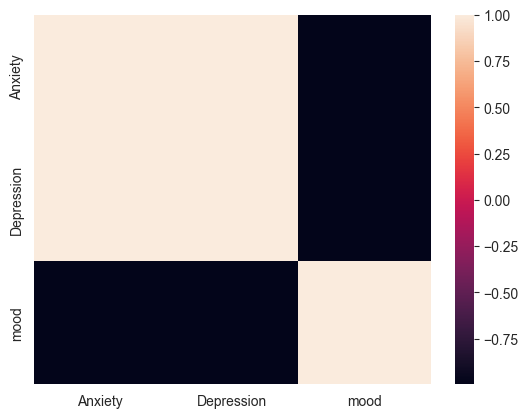

In [148]:
sns.heatmap(banda_data[["Anxiety", "Depression", "mood"]].corr())

In [149]:
clustering_df = pd.concat([banda_data, pdc_data])

In [155]:
pca_df = clustering_df[['interview_age', 'sex', 'Anxiety', 'Depression', 'mood'
      ]]
pca_df['sex'] = pca_df['sex'].apply(lambda x: 1 if x=="F" else 0)
pca_df['interview_age'] = pca_df['interview_age'].astype('float')
normalised_data = scaling(pca_df)
dat = pca_permulation(pca_df, normalised_data)
pca_dat = fit_pca(dat, normalised_data)
determine_number_of_clusters(pca_dat)

For n_clusters = 2 The average silhouette_score is : 0.5735065051881701
For n_clusters = 3 The average silhouette_score is : 0.5058388806552089
For n_clusters = 4 The average silhouette_score is : 0.604123736235081
For n_clusters = 5 The average silhouette_score is : 0.5736434123111703
For n_clusters = 6 The average silhouette_score is : 0.5332397794586179
For n_clusters = 7 The average silhouette_score is : 0.548702308114525
For n_clusters = 8 The average silhouette_score is : 0.5488678208018519
For n_clusters = 9 The average silhouette_score is : 0.5324435571640824
For n_clusters = 10 The average silhouette_score is : 0.536861781629421


In [ ]:
from sklearn.cluster import MeanShift
mean_shift = MeanShift()
labels = mean_shift.fit_predict(pca_dat)

In [194]:
from sklearn.cluster import 
from sklearn.mixture import GaussianMixture



SyntaxError: invalid syntax (1926848381.py, line 1)

In [183]:
clusterer.fit(pca_dat)


SpectralClustering(n_components=2, random_state=10)

In [195]:
for cluster_n in range(2, 11):
        clusterer = GaussianMixture(n_components=cluster_n, random_state=10)
        cluster_labels = clusterer.fit_predict(pca_dat)
        silhouette_avg = silhouette_score(pca_dat, cluster_labels)
        print("For n_clusters =", cluster_n, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.5679459064700734
For n_clusters = 3 The average silhouette_score is : 0.5239143945451095
For n_clusters = 4 The average silhouette_score is : 0.5999240846240318
For n_clusters = 5 The average silhouette_score is : 0.5715067097274622
For n_clusters = 6 The average silhouette_score is : 0.5318066686694979
For n_clusters = 7 The average silhouette_score is : 0.5481644548874087
For n_clusters = 8 The average silhouette_score is : 0.5416983018746285
For n_clusters = 9 The average silhouette_score is : 0.5310140134279122
For n_clusters = 10 The average silhouette_score is : 0.5331486491218974


In [197]:
cluster = GaussianMixture(n_components=4)
labels = cluster.fit_predict(pca_dat)

In [156]:
clusters = clustering(4, pca_dat)

In [198]:
clustering_df['group'] = labels


In [199]:
group = clustering_df.groupby("group")
numbers = group.count()['sex'].rename("Count")
phenotype = group['phenotype'].unique().rename("phenotype")
number_in_each_group = group['phenotype'].value_counts().T
pd.concat([numbers, phenotype, group[["Anxiety", "Depression"]].mean(),], axis=1)

,Count,phenotype,Anxiety,Depression
group,,,,
0,83,"[Control, Anxiety, Depression, MDD]",-2.424412,-3.232919
1,106,"[Depression, Anxiety, MDD, Control]",1.512133,2.121750
2,205,"[Control, Depression, Anxiety, MDD]",-0.320728,-0.471790
3,25,"[Depression, Anxiety]",4.267571,5.605749


In [200]:
number_in_each_group

group  phenotype 
0      Control        59
       MDD            11
       Anxiety        10
       Depression      3
1      MDD            53
       Depression     27
       Anxiety        24
       Control         2
2      MDD           102
       Control        52
       Anxiety        36
       Depression     15
3      Depression     18
       Anxiety         7
Name: count, dtype: int64

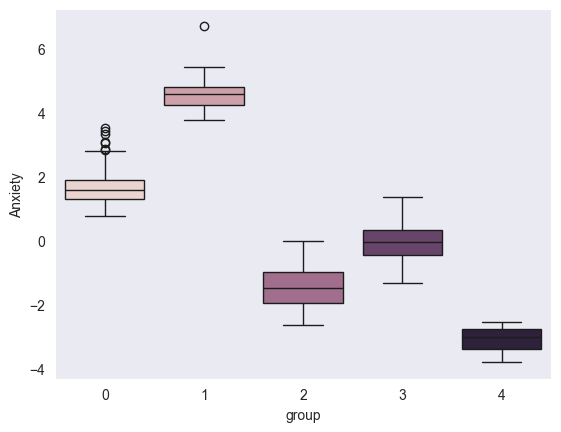

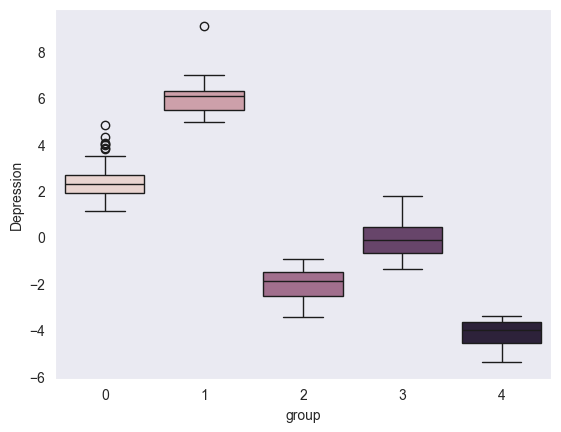

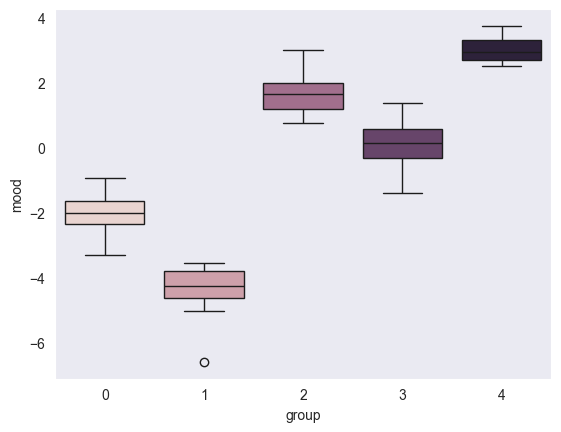

In [192]:
for val in ['Anxiety', 'Depression','mood']:
    plot = sns.boxplot(data=clustering_df, x='group', y=val, hue='group')
    plot.get_legend().remove()
    plt.show()